# Rainbow Trout Genotype-Based Gender Prediction

This project focuses on using genomic data to accurately predict the gender of rainbow trout (*Oncorhynchus mykiss*). Gender identification in fish is crucial for effective breeding and management practices, but traditional methods are invasive, time-consuming, and unreliable for juvenile fish. 

By leveraging machine learning and genomic data, this project aims to develop a robust and efficient model for identifying fish gender.


## Importing necessary packages

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

%autosave 30

Autosaving every 30 seconds


In [3]:
SEED = 32 # Random State

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, accuracy_score

## Data
The information regarding the data in the paper mentions that the first column is the target column, indication of the gender of the rainbow trout fish.
* Male : 0
* Female : 1

The remaining columns are the SNPs of the rainbow trout. There is a _unified error rate (in %)_ across all SNPs, indicated by the number at the end of the data file's name. A _unified error rate_ across all SNPs means that the same percentage of genotyping errors was applied to every single nucleotide polymorphism (SNP) marker in the dataset.

For the Sim_5 dataset, a 5% unified error rate was used. This means that for each of the 15 SNP markers:
* 5% of the non-missing genotypes were randomly selected to deviate from the ground truth model.
* The same 5% error rate was applied consistently across all 15 SNPs.

Additionally, a few samples with missing SNP information were selected randomly. The missing SNP genotypes were coded as 5.

In [4]:
print("Available Data:")
os.listdir("./data")

Available Data:


['sim_random.dat',
 'sim_5.dat',
 '.DS_Store',
 'sim_real.dat',
 'modelRecord.csv',
 'sim_50.dat']

In [5]:
# List of column names
# GN: Gender, M{i}: Marker{i} for i:(1,15)
columnName = ['GN'] + [f'M{i}' for i in range(1,16)]

In [6]:
dataPath = "./data/sim_real.dat"
# dataPath = "./data/sim_50.dat"
# dataPath = "./data/sim_random.dat"
# dataPath = "./data/sim_5.dat"

data = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
data.replace(5, np.nan, inplace=True)
print(f"Shape of data: {data.shape}")
data.head()

Shape of data: (14010, 16)


,GN,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15
0,1,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0
1,1,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
2,0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0
3,1,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,NaN,2.0,2.0,1.0,2.0,2.0,1.0
4,1,2.0,NaN,NaN,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,NaN,NaN,1.0


The data in the markers is represented as follows:
* Heterozygous genotype: Coded as 1
* Homozygous genotype: Coded as 2
* Missing data: Initially coded as 5, then converted to ‘not-a-number’ (nan) during analysis

In genetics, heterozygous and homozygous refer to the genetic composition of an organism for a particular trait or gene.
* An organism is heterozygous when it carries two different alleles (versions) of a gene. Male rainbow trout were assumed to be heterozygous
* An organism is homozygous when it carries two identical alleles of a gene. Female rainbow trout were assumed to be homozygous

In [7]:
print(f"Number of rows with a missing SNP in their sequence: {data[data.isna().any(axis=1)].shape[0]} ")
print(f"Total numer of sequences: {data.shape[0]}\n")
print(f"Ratio to missing sequences: {data[data.isna().any(axis=1)].shape[0]*100/data.shape[0]} %")

Number of rows with a missing SNP in their sequence: 7438 
Total numer of sequences: 14010

Ratio to missing sequences: 53.09064953604568 %


More that 50% of the data samples have atleast one missing SNP.

## Exploring Data

In [8]:
# Distribution of the gender class
data['GN'].replace({1:'Female',0:'Male'}).value_counts(normalize=True)*100

GN
Female    60.0
Male      40.0
Name: proportion, dtype: float64

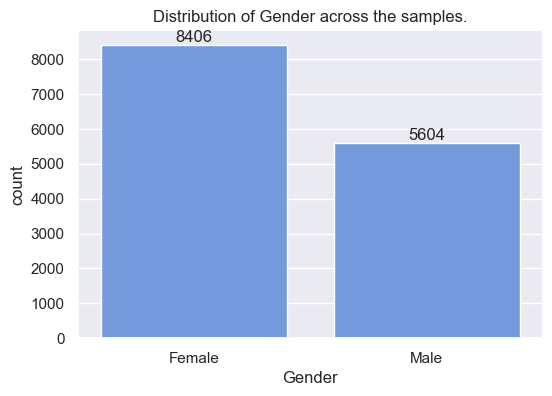

In [9]:
color = 'cornflowerblue'
plt.figure(figsize = (6,4), dpi = 100)
ax = sns.barplot(data=data['GN'].replace({1:'Female',0:'Male'}).value_counts(), color=color)
for i in ax.containers:
    ax.bar_label(i,)
plt.title("Distribution of Gender across the samples.")
plt.xlabel("Gender")
plt.show()

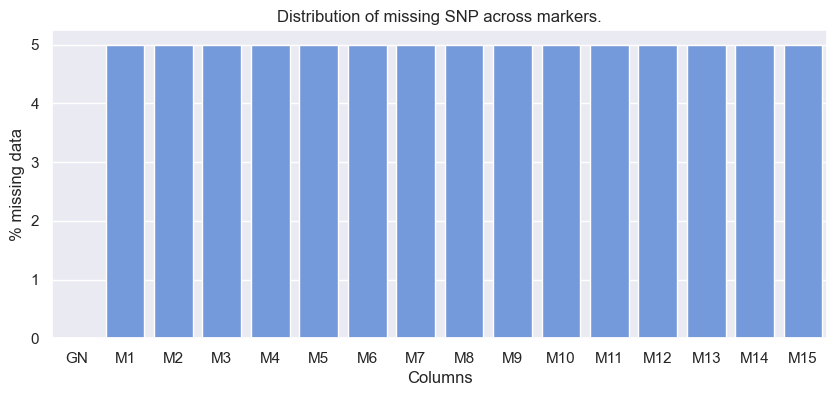

In [10]:
fnx = lambda col : col[col.isna()].shape[0]*100/col.shape[0]
plt.figure(figsize = (10,4), dpi = 100)
sns.barplot(data=data.apply(fnx), color=color)
plt.title("Distribution of missing SNP across markers.")
plt.xlabel("Columns")
plt.ylabel("% missing data")
plt.show()

This indicates that about 700 samples per marker was missing among all the samples. This was cross validated with the paper too.

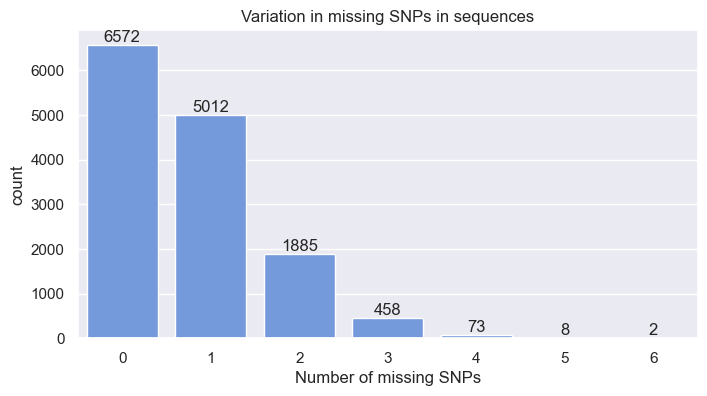

In [11]:
missData = data.isna().sum(axis=1)

plt.figure(figsize = (8,4), dpi = 100)
ax = sns.barplot(data=missData.value_counts(normalize=False), color = color)
for i in ax.containers:
    ax.bar_label(i,)

plt.title("Variation in missing SNPs in sequences")
plt.xlabel("Number of missing SNPs")
plt.show()

In [12]:
%%time
fnx = lambda row: row.value_counts(normalize=False,dropna=False)
dataCount = data.iloc[:,1:].apply(fnx,axis=1).fillna(0)
dataCount.columns = ['HETEROZ','HOMOZ','MISS']
dataCount = dataCount.assign(GENDER = data['GN'])
dataCount['GENDER'] = dataCount['GENDER'].replace({0:'MALE',1:'FEMALE'})
dataCount.head()

CPU times: user 1.61 s, sys: 20.6 ms, total: 1.63 s
Wall time: 1.2 s


,HETEROZ,HOMOZ,MISS,GENDER
0,4.0,11.0,0.0,FEMALE
1,2.0,13.0,0.0,FEMALE
2,9.0,6.0,0.0,MALE
3,2.0,11.0,2.0,FEMALE
4,6.0,5.0,4.0,FEMALE


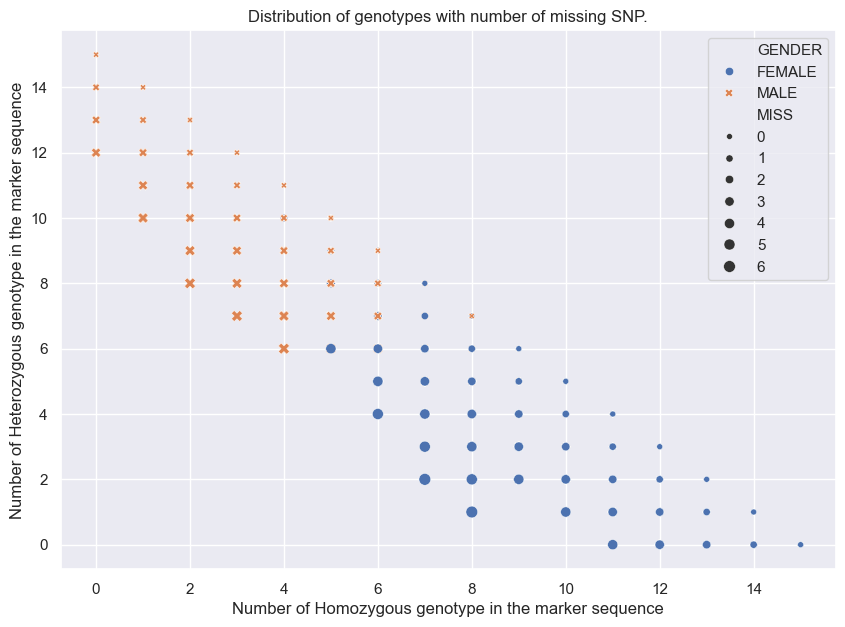

In [13]:
plt.figure(figsize = (10,7), dpi = 100)
sns.scatterplot(data=dataCount, x='HOMOZ', y='HETEROZ', size='MISS', style='GENDER', hue ='GENDER')
plt.title("Distribution of genotypes with number of missing SNP.")
plt.xlabel("Number of Homozygous genotype in the marker sequence")
plt.ylabel("Number of Heterozygous genotype in the marker sequence")
plt.show()

### Auxiliary Functions

In [14]:
def resultAnalysisFnx(ytrue,ypred,target_names=['MALE','FEMALE']):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names))
    else:
        print(classification_report(ytrue,ypred))

    conf_matrix = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(6, 4))
    if target_names != None:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names, linewidths=0.8, linecolor='black')
    else:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, linewidths=0.8, linecolor='black')

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True)

In [15]:
if 'modelRecord.csv' in os.listdir('./data'):
  modelRecord = pd.read_csv('./data'+'/'+'modelRecord.csv')
else:
  modelRecord = pd.DataFrame({'ModelName':[],'testAccuracy':[],'testF1':[],'testPrecision':[],'testRecall':[]})
  modelRecord.to_csv('./data'+'/'+'modelRecord.csv',index=False)

def resultRecordFnx(report,modelname,modelRecord=modelRecord):
  '''
  Feed classification report, modelname
  '''
  acc,pre,rec,f1 = report['accuracy'],report['macro avg']['precision'],report['macro avg']['recall'],report['macro avg']['f1-score']
  if modelname in modelRecord['ModelName'].values:
    modelRecord.loc[modelRecord['ModelName'] == modelname,:] = [modelname,acc,f1,pre,rec]
  else:
    modelRecord.loc[len(modelRecord)] = {'ModelName':modelname,'testAccuracy':acc,'testF1':f1,'testPrecision':pre,'testRecall':rec}
  modelRecord.to_csv('./data'+'/'+'modelRecord.csv',index=False)


In [16]:
modelRecord

,ModelName,testAccuracy,testF1,testPrecision,testRecall
0,H1LogRegSim_real,0.982869,0.982148,0.982341,0.981957
1,H1LogRegSim_5,1.000000,1.000000,1.000000,1.000000
2,H1SVMSim_real,0.982394,0.981648,0.981939,0.981362
3,H1SVMSim_5,1.000000,1.000000,1.000000,1.000000
4,H1KNNSim_real,0.982394,0.981648,0.981939,0.981362
5,H1KNNSim_5,1.000000,1.000000,1.000000,1.000000


## Hypothesis 1
As a general trend, we can comment that, the more heterozygous genotypes the sequence has, the higher chance for the fish to be a male. A simple model can be built on top of this comment.

Potential Algorithms:
* Logistic Regression (for classification tasks)
* Support Vector Machines

In [17]:
%%time
dataPath = "./data/sim_real.dat"

data = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
data.replace(5, np.nan, inplace=True)

CPU times: user 20.6 ms, sys: 2.69 ms, total: 23.3 ms
Wall time: 8.99 ms


In [18]:
%%time
fnx = lambda row: row.value_counts(normalize=False,dropna=False)
dataCount = data.iloc[:,1:].apply(fnx,axis=1).fillna(0)
dataCount.columns = ['HETEROZ','HOMOZ','MISS']
dataCount = dataCount.assign(GENDER = data['GN'])
# dataCount['GENDER'] = dataCount['GENDER'].replace({0:'MALE',1:'FEMALE'})
dataCount.head()

CPU times: user 1.22 s, sys: 21 ms, total: 1.24 s
Wall time: 1.21 s


,HETEROZ,HOMOZ,MISS,GENDER
0,4.0,11.0,0.0,1
1,2.0,13.0,0.0,1
2,9.0,6.0,0.0,0
3,2.0,11.0,2.0,1
4,6.0,5.0,4.0,1


### Logistic Regression

In [19]:
# Importing the package for Logistic Regression
from sklearn.linear_model import LogisticRegression

In [20]:
inpData, tarData = dataCount.iloc[:,:-1], dataCount.iloc[:,-1]

print("Shapes of input & target data:")
print(inpData.shape, tarData.shape)

Shapes of input & target data:
(14010, 3) (14010,)


In [21]:
# Since we do not have anamolies in the data, we can Normalization over Standardization.
scaler = MinMaxScaler()

inpData_sca = scaler.fit_transform(inpData)

In [22]:
inpData_sca.shape

(14010, 3)

In [23]:
# Splitting the data into training (70%) and testing data (30%)
xtrain, xtest, ytrain, ytest = train_test_split(inpData_sca, tarData, test_size=0.3, stratify=tarData)

print(f"Size of training data: {xtrain.shape} \nSize of testing data: {xtest.shape}")

Size of training data: (9807, 3) 
Size of testing data: (4203, 3)


In [24]:
%%time
# Since the gender/target class is not heavily imbalanced, we can attempt NOT having class weights for now.
logRes_clf = LogisticRegression(random_state=SEED)

logRes_clf.fit(xtrain, ytrain)

CPU times: user 118 ms, sys: 3.85 ms, total: 121 ms
Wall time: 20.7 ms


LogisticRegression(random_state=32)

In [25]:
%%time
ypred = logRes_clf.predict(xtest)

CPU times: user 1.65 ms, sys: 2.17 ms, total: 3.82 ms
Wall time: 715 µs


              precision    recall  f1-score   support

        MALE       0.98      0.98      0.98      1681
      FEMALE       0.99      0.99      0.99      2522

    accuracy                           0.98      4203
   macro avg       0.98      0.98      0.98      4203
weighted avg       0.98      0.98      0.98      4203



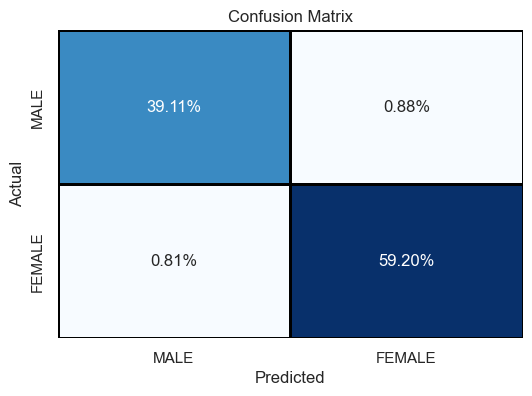

In [26]:
report = resultAnalysisFnx(ytest, ypred, ['MALE','FEMALE'])

In [27]:
resultRecordFnx(report, "H1LogRegSim_real")

In [28]:
modelRecord

,ModelName,testAccuracy,testF1,testPrecision,testRecall
0,H1LogRegSim_real,0.983107,0.982397,0.982542,0.982254
1,H1LogRegSim_5,1.000000,1.000000,1.000000,1.000000
2,H1SVMSim_real,0.982394,0.981648,0.981939,0.981362
3,H1SVMSim_5,1.000000,1.000000,1.000000,1.000000
4,H1KNNSim_real,0.982394,0.981648,0.981939,0.981362
5,H1KNNSim_5,1.000000,1.000000,1.000000,1.000000


#### Different Datasets

In [29]:
%%time
dataPath = "./data/sim_5.dat"

dataV2 = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
dataV2.replace(5, np.nan, inplace=True)

fnx = lambda row: row.value_counts(normalize=False,dropna=False)
dataV2Count = dataV2.iloc[:,1:].apply(fnx,axis=1).fillna(0)
dataV2Count.columns = ['HETEROZ','HOMOZ','MISS']
dataV2Count = dataV2Count.assign(GENDER = dataV2['GN'])
# dataCount['GENDER'] = dataCount['GENDER'].replace({0:'MALE',1:'FEMALE'})
# dataV2Count.head()

inpDataV2, tarDataV2 = dataV2Count.iloc[:,:-1], dataV2Count.iloc[:,-1]

inpDataV2_sca = scaler.transform(inpDataV2)

CPU times: user 1.6 s, sys: 607 ms, total: 2.21 s
Wall time: 1.18 s


              precision    recall  f1-score   support

        MALE       1.00      1.00      1.00      5604
      FEMALE       1.00      1.00      1.00      8406

    accuracy                           1.00     14010
   macro avg       1.00      1.00      1.00     14010
weighted avg       1.00      1.00      1.00     14010



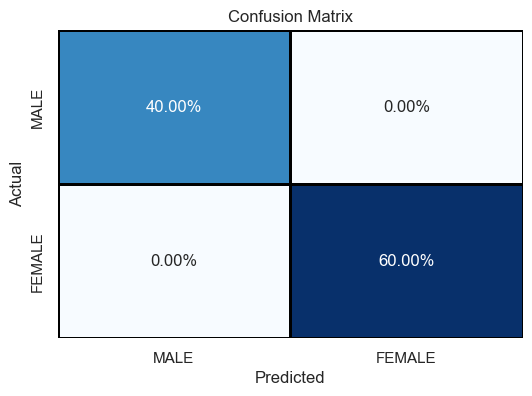

CPU times: user 349 ms, sys: 520 ms, total: 869 ms
Wall time: 116 ms


In [30]:
%%time
ypredV2 = logRes_clf.predict(inpDataV2_sca)
report = resultAnalysisFnx(tarDataV2, ypredV2)

In [31]:
resultRecordFnx(report, "H1LogRegSim_5")

In [32]:
modelRecord

,ModelName,testAccuracy,testF1,testPrecision,testRecall
0,H1LogRegSim_real,0.983107,0.982397,0.982542,0.982254
1,H1LogRegSim_5,1.000000,1.000000,1.000000,1.000000
2,H1SVMSim_real,0.982394,0.981648,0.981939,0.981362
3,H1SVMSim_5,1.000000,1.000000,1.000000,1.000000
4,H1KNNSim_real,0.982394,0.981648,0.981939,0.981362
5,H1KNNSim_5,1.000000,1.000000,1.000000,1.000000


### Logistic Regression Cross Validation

On Data: Sim_real

In [36]:
%%time
dataPath = "./data/sim_random.dat"

dataV2 = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
dataV2.replace(5, np.nan, inplace=True)

fnx = lambda row: row.value_counts(normalize=False,dropna=False)
dataV2Count = dataV2.iloc[:,1:].apply(fnx,axis=1).fillna(0)
dataV2Count.columns = ['HETEROZ','HOMOZ','MISS']
dataV2Count = dataV2Count.assign(GENDER = dataV2['GN'])
# dataCount['GENDER'] = dataCount['GENDER'].replace({0:'MALE',1:'FEMALE'})
# dataV2Count.head()

inpDataV2, tarDataV2 = dataV2Count.iloc[:,:-1], dataV2Count.iloc[:,-1]

inpDataV2_sca = scaler.transform(inpDataV2)

CPU times: user 1.16 s, sys: 15.9 ms, total: 1.18 s
Wall time: 1.17 s


In [37]:
FOLDS = 10
yscores = cross_val_score(logRes_clf, inpDataV2_sca, tarDataV2, cv = FOLDS)

print(f"Cross Validation of {FOLDS} folds\nMean Accuracy: {yscores.mean():.5f} Standard Deviation: {yscores.std():.5f}")

Cross Validation of 10 folds
Mean Accuracy: 0.99029 Standard Deviation: 0.00226


The **Precision-Recall vs Threshold curve** shows the relationship between precision and recall at various decision thresholds in a classification model. By adjusting the threshold, you can optimize the balance between precision (the accuracy of positive predictions) and recall (the ability to identify all positive instances).

* Precision: Precision tells you how many of the things the model said were positive are actually positive. It answers, 'Of all the positives predicted, how many were right?'"

* Recall: "Recall tells you how many of the actual positives the model was able to find. It answers, 'Of all the real positives, how many did the model catch?'"

In [112]:
yscores = cross_val_predict(logRes_clf, inpDataV2_sca, tarDataV2, cv = FOLDS, method='decision_function')
precision, recall, threshold = precision_recall_curve(tarDataV2, yscores)

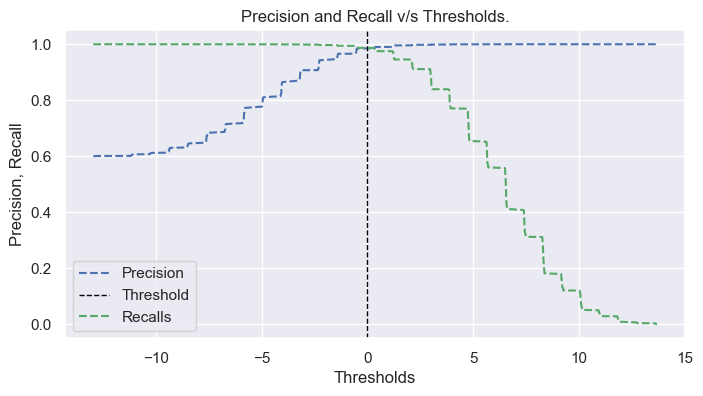

In [137]:
plt.figure(figsize=(8, 4), dpi = 100)
plt.grid(True)
plt.plot(threshold, precision[:-1], "b--", label='Precision')

# plt.axvline(x=threshold[:-1][289], color='r', linestyle='--', label='Threshold Cutoff.', lw=1)
plt.axvline(x=0, color='black', linestyle='--', label='Threshold', lw=1)

# plt.twinx()
# plt.grid(False)
# plt.legend(loc=7)

plt.plot(threshold, recall[:-1], "g--", label='Recalls')
plt.legend(loc='best')
plt.xlabel("Thresholds")
plt.ylabel("Precision, Recall")
plt.title("Precision and Recall v/s Thresholds.")
plt.show()

### Support Vector Machines

In [33]:
from sklearn.svm import SVC

In [34]:
%%time
# Since the gender/target class is not heavily imbalanced, we can attempt NOT having class weights for now.
svc_clf = SVC(random_state=SEED)

svc_clf.fit(xtrain, ytrain)

CPU times: user 98.7 ms, sys: 5.66 ms, total: 104 ms
Wall time: 103 ms


SVC(random_state=32)

In [35]:
%%time
ypred = svc_clf.predict(xtest)

CPU times: user 82.5 ms, sys: 4.41 ms, total: 87 ms
Wall time: 103 ms


              precision    recall  f1-score   support

        MALE       0.98      0.98      0.98      1681
      FEMALE       0.98      0.99      0.99      2522

    accuracy                           0.98      4203
   macro avg       0.98      0.98      0.98      4203
weighted avg       0.98      0.98      0.98      4203



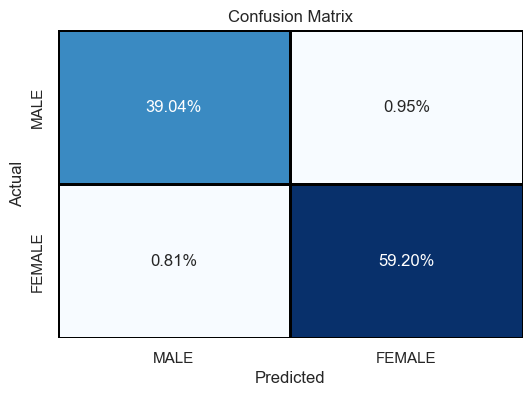

In [36]:
report = resultAnalysisFnx(ytest, ypred, ['MALE','FEMALE'])

In [37]:
resultRecordFnx(report, "H1SVMSim_real")

#### Different Datasets

In [38]:
%%time
dataPath = "./data/sim_5.dat"

dataV2 = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
dataV2.replace(5, np.nan, inplace=True)

fnx = lambda row: row.value_counts(normalize=False,dropna=False)
dataV2Count = dataV2.iloc[:,1:].apply(fnx,axis=1).fillna(0)
dataV2Count.columns = ['HETEROZ','HOMOZ','MISS']
dataV2Count = dataV2Count.assign(GENDER = dataV2['GN'])
# dataCount['GENDER'] = dataCount['GENDER'].replace({0:'MALE',1:'FEMALE'})
# dataV2Count.head()

inpDataV2, tarDataV2 = dataV2Count.iloc[:,:-1], dataV2Count.iloc[:,-1]

inpDataV2_sca = scaler.transform(inpDataV2)

CPU times: user 1.15 s, sys: 19.4 ms, total: 1.17 s
Wall time: 1.16 s


              precision    recall  f1-score   support

        MALE       1.00      1.00      1.00      5604
      FEMALE       1.00      1.00      1.00      8406

    accuracy                           1.00     14010
   macro avg       1.00      1.00      1.00     14010
weighted avg       1.00      1.00      1.00     14010



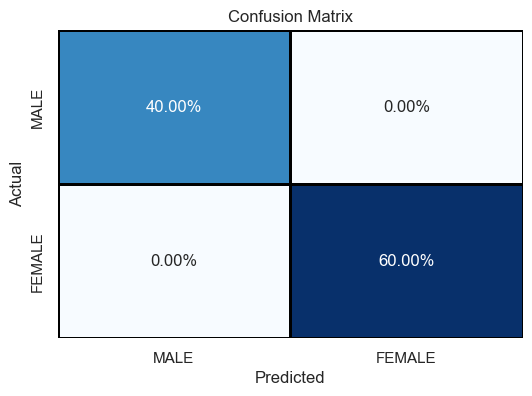

CPU times: user 335 ms, sys: 4.97 ms, total: 340 ms
Wall time: 278 ms


In [39]:
%%time
ypredV2 = svc_clf.predict(inpDataV2_sca)
report = resultAnalysisFnx(tarDataV2, ypredV2)

In [40]:
resultRecordFnx(report, "H1SVMSim_5")

In [41]:
modelRecord

,ModelName,testAccuracy,testF1,testPrecision,testRecall
0,H1LogRegSim_real,0.982394,0.981648,0.981939,0.981362
1,H1LogRegSim_5,1.000000,1.000000,1.000000,1.000000
2,H1SVMSim_real,0.982394,0.981648,0.981939,0.981362
3,H1SVMSim_5,1.000000,1.000000,1.000000,1.000000


### K Nearest Neighbour

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
%%time

error_rates = []

for k in tqdm(range(2, 20)):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    ypred = knn.predict(xtest)
    error_rate = 1 - accuracy_score(ytest, ypred)
    error_rates.append(error_rate)

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 18.04it/s]

CPU times: user 991 ms, sys: 48.6 ms, total: 1.04 s
Wall time: 1.02 s


The plot below shows that at k = 5, the error rate reduces to a great degree.

We can safely assign a **k of 5** in this case.

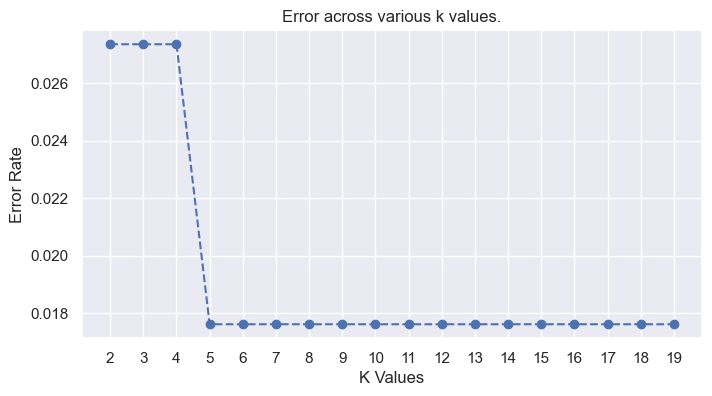

In [44]:
plt.figure(figsize=(8, 4), dpi = 100)
plt.plot(range(2, 20), error_rates, marker='o', linestyle='dashed')
plt.xticks(ticks = range(2, 20))
plt.xlabel("K Values")
plt.ylabel("Error Rate")
plt.title("Error across various k values.")
plt.show()

In [45]:
%%time
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(xtrain, ytrain)

ypred = knn_clf.predict(xtest)

CPU times: user 91.9 ms, sys: 3.81 ms, total: 95.7 ms
Wall time: 94.1 ms


              precision    recall  f1-score   support

        MALE       0.98      0.98      0.98      1681
      FEMALE       0.98      0.99      0.99      2522

    accuracy                           0.98      4203
   macro avg       0.98      0.98      0.98      4203
weighted avg       0.98      0.98      0.98      4203



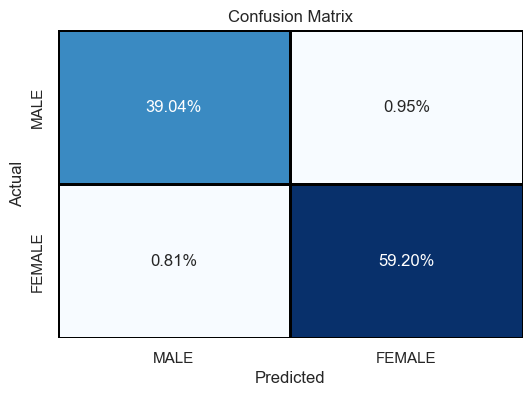

In [46]:
report = resultAnalysisFnx(ytest, ypred, ['MALE','FEMALE'])

In [47]:
resultRecordFnx(report, "H1KNNSim_real")

#### Different Dataset

In [48]:
%%time
dataPath = "./data/sim_5.dat"

dataV2 = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
dataV2.replace(5, np.nan, inplace=True)

fnx = lambda row: row.value_counts(normalize=False,dropna=False)
dataV2Count = dataV2.iloc[:,1:].apply(fnx,axis=1).fillna(0)
dataV2Count.columns = ['HETEROZ','HOMOZ','MISS']
dataV2Count = dataV2Count.assign(GENDER = dataV2['GN'])
# dataCount['GENDER'] = dataCount['GENDER'].replace({0:'MALE',1:'FEMALE'})
# dataV2Count.head()

inpDataV2, tarDataV2 = dataV2Count.iloc[:,:-1], dataV2Count.iloc[:,-1]

inpDataV2_sca = scaler.transform(inpDataV2)

CPU times: user 1.09 s, sys: 22.2 ms, total: 1.12 s
Wall time: 1.11 s


              precision    recall  f1-score   support

        MALE       1.00      1.00      1.00      5604
      FEMALE       1.00      1.00      1.00      8406

    accuracy                           1.00     14010
   macro avg       1.00      1.00      1.00     14010
weighted avg       1.00      1.00      1.00     14010



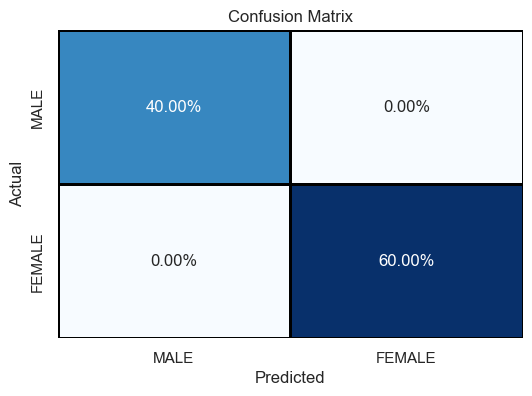

CPU times: user 294 ms, sys: 6.92 ms, total: 301 ms
Wall time: 261 ms


In [49]:
%%time
ypredV2 = knn_clf.predict(inpDataV2_sca)
report = resultAnalysisFnx(tarDataV2, ypredV2)

In [50]:
resultRecordFnx(report, "H1KNNSim_5")

---
## Hypothesis 2
The sequence of genotypes can indicate the gender. Visualize the sequences according to according to the genders

_Hypothesis:_ 
* The starting 5 markers (M1-M5) may be the most decisive indicators to the fish's gender.
* We may not need all the markers to indicate the gender of the fish.

In [51]:
%%time
dataPath = "./data/sim_real.dat"

data = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
data.replace(5, np.nan, inplace=True)

CPU times: user 16.6 ms, sys: 4.79 ms, total: 21.4 ms
Wall time: 19.6 ms


In [52]:
%%time

dropnaFlag = False

fnx = lambda grp: grp.apply(lambda row: row.value_counts(normalize=True, dropna=dropnaFlag))
genoFreq = data.groupby('GN').apply(fnx, include_groups=False).fillna(0)

CPU times: user 20.4 ms, sys: 3.82 ms, total: 24.3 ms
Wall time: 22.4 ms


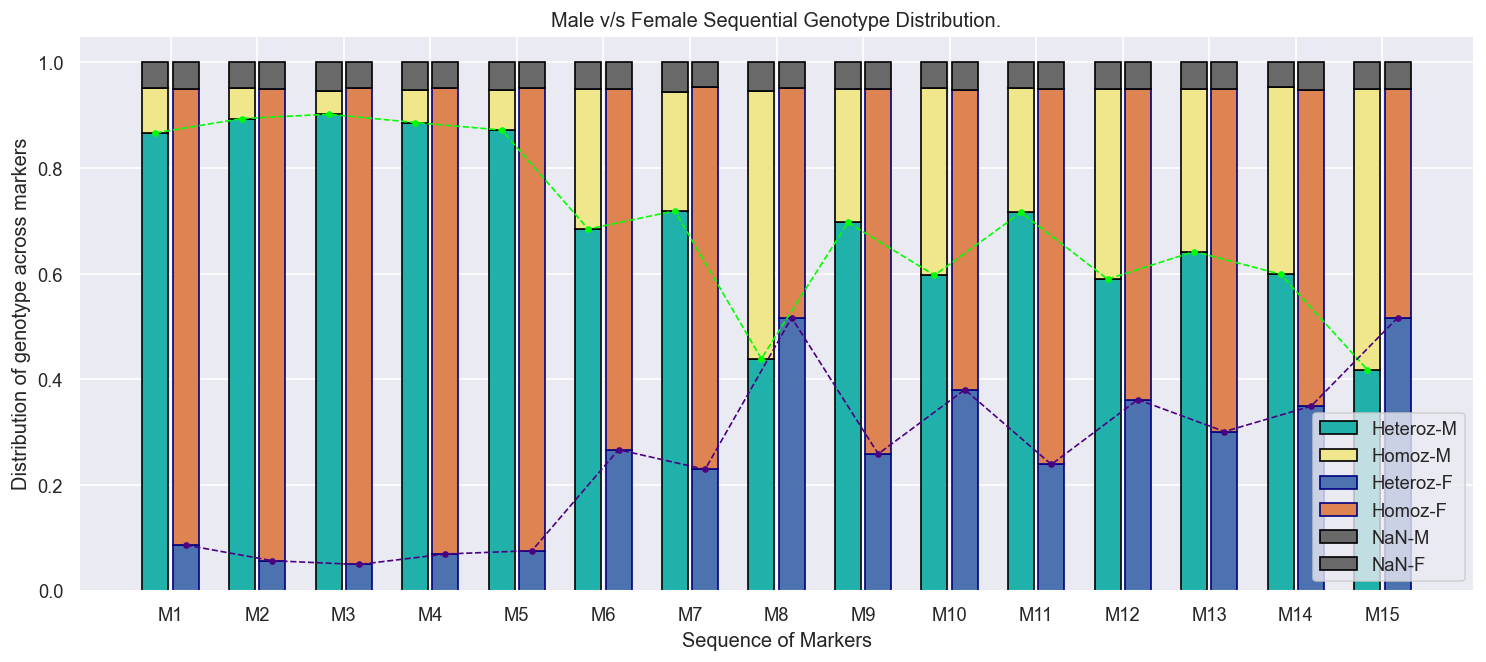

In [53]:
idx = np.arange(genoFreq.shape[1])

plt.figure(figsize = (15,6), dpi = 120)

ym1, ym2 = genoFreq.loc[0].loc[1].values, genoFreq.loc[0].loc[2].values
yf1, yf2 = genoFreq.loc[1].loc[1].values, genoFreq.loc[1].loc[2].values

width,off,logFlag = 0.3, 0.05, False

plt.bar(idx, ym1, width, color='lightseagreen', label = 'Heteroz-M', edgecolor = "black", log=logFlag)
plt.bar(idx, ym2, width, bottom = ym1 , color = 'khaki', label='Homoz-M', edgecolor = "black", log=logFlag)

plt.bar(idx+width+off, yf1, width, label = 'Heteroz-F', edgecolor='navy', log=logFlag)
plt.bar(idx+width+off, yf2, width, bottom = yf1, label='Homoz-F', edgecolor='navy', log=logFlag)

plt.plot(idx, ym1,marker='o', linestyle='dashed',linewidth=1, markersize=3, color = 'lime')
plt.plot(idx+width+off, yf1,marker='o', linestyle='dashed',linewidth=1, markersize=3, color = 'indigo')

if dropnaFlag!=True:
    ym3, yf3 = genoFreq.loc[0].loc[np.nan].values, genoFreq.loc[1].loc[np.nan].values
    plt.bar(idx, ym3, width, bottom = ym1+ym2 , color = 'dimgrey', label='NaN-M', edgecolor = "black", log=logFlag)
    plt.bar(idx+width+off, yf3, width, bottom = yf1+yf2 , color = 'dimgrey', label='NaN-F', edgecolor = "black", log=logFlag)
    

plt.xticks((idx+(width+off)/ 2), genoFreq.columns)
plt.xlabel("Sequence of Markers")
plt.ylabel("Distribution of genotype across markers")

plt.legend(loc='best')

plt.title("Male v/s Female Sequential Genotype Distribution.")
plt.show()

### Logistic Regression

In [147]:
%%time
# Replacing NaN values with 3
datah2 = data.fillna(3)
inpData, tarData = datah2.iloc[:,1:], datah2.iloc[:,0]

CPU times: user 5.39 ms, sys: 3.73 ms, total: 9.12 ms
Wall time: 6.99 ms


In [148]:
# Splitting the data into training (70%) and testing data (30%)
xtrain, xtest, ytrain, ytest = train_test_split(inpData, tarData, test_size=0.3, stratify=tarData)

print(f"Size of training data: {xtrain.shape} \nSize of testing data: {xtest.shape}")

Size of training data: (9807, 15) 
Size of testing data: (4203, 15)


In [152]:
%%time
# Since the gender/target class is not heavily imbalanced, we can attempt NOT having class weights for now.
logRes_clf = LogisticRegression(random_state=SEED)

logRes_clf.fit(xtrain, ytrain)

CPU times: user 242 ms, sys: 9.09 ms, total: 251 ms
Wall time: 50 ms


LogisticRegression(random_state=32)

              precision    recall  f1-score   support

        MALE       0.98      0.97      0.98      1681
      FEMALE       0.98      0.99      0.98      2522

    accuracy                           0.98      4203
   macro avg       0.98      0.98      0.98      4203
weighted avg       0.98      0.98      0.98      4203



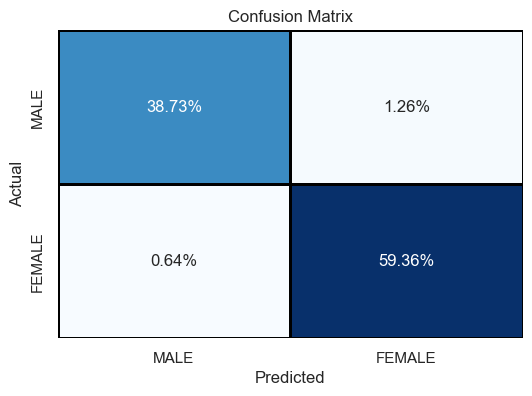

CPU times: user 374 ms, sys: 253 ms, total: 627 ms
Wall time: 91.6 ms


In [153]:
%%time
ypred = logRes_clf.predict(xtest)

report = resultAnalysisFnx(ytest, ypred, ['MALE','FEMALE'])